In [2]:
import datetime
import pickle
import os.path

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import dendropy

from spectraltree import *

In [5]:
def unrooted_birth_death_tree(birth_rate, death_rate,  birth_rate_sd=0.0, death_rate_sd=0.0, **kwargs):
    tree = birth_death_tree(birth_rate, death_rate, birth_rate_sd=birth_rate_sd, death_rate_sd=death_rate_sd, **kwargs)
    tree.is_rooted = False
    return tree

In [6]:

def check_partition_in_tree(tree,partition):
    
    # UGLY!! The bipartitions in 'tree' is given by order of taxonomy (T1,T2 etc)
    # The input 'partition' is via order of the appearnace in the matrix 
    # The first step is to switch partition such that it is of the same order of tree
    ns = []
    for leaf_ix, leaf in enumerate(tree.leaf_node_iter()):    
        ns.append(int(leaf.taxon.label[0:]))
    ns_idx = np.argsort(np.array(ns))
    partition = partition[ns_idx]
    partition_inv = [not i for i in partition]
    

    #print("*********************")
    tree_bipartitions = tree.bipartition_edge_map
    flag = False
    for bp in tree_bipartitions.keys():
        bool_array =np.array(list(map(bool,[int(i) for i in bp.leafset_as_bitstring()]))[::-1])
        #bool_array = bool_array[ns_idx]
        #print(bool_array)
        if np.array_equal(bool_array,partition) or np.array_equal(bool_array,partition_inv):
            flag = True
    return flag  
    
def partition_taxa(v):
    m = len(v)
    v_sort = np.sort(v)
    gaps = v_sort[1:m]-v_sort[0:m-1]
    max_idx = np.argmax(gaps)
    threshold = (v_sort[max_idx]+v_sort[max_idx+1])/2
    bool_bipartition = v<threshold
    return bool_bipartition
    

In [3]:

class Experiment_Datum:
    def __init__(self, sequence_model, n, method, mutation_rate, inferred_tree, reference_tree):
        self.sequence_model = sequence_model
        self.n = n
        self.method = method
        self.mutation_rate = mutation_rate
        inferred_tree.update_bipartitions()
        reference_tree.update_bipartitions()
        self.ref_tree = reference_tree
        # self.inf_tree = inferred_tree   # take this out for space/speed
        self.false_positives, self.false_negatives = dendropy.calculate.treecompare.false_positives_and_negatives(reference_tree, inferred_tree, is_bipartitions_updated=True)
        self.total_reference = len(reference_tree.bipartition_encoding)
        self.total_inferred = len(inferred_tree.bipartition_encoding)
        self.timestamp = datetime.datetime.now()

    @property
    def m(self):
        return len(self.ref_tree.leaf_edges())

    @property
    def RF(self):
        # source: https://dendropy.org/_modules/dendropy/calculate/treecompare.html#symmetric_difference
        return self.false_positives + self.false_negatives

    @property
    def precision(self):
        true_positives = self.total_inferred - self.false_positives
        return true_positives / self.total_inferred

    @property
    def recall(self):
        true_positives = self.total_inferred - self.false_positives
        return true_positives / self.total_reference

    @property
    def F1(self):
        return 2*(self.precision * self.recall)/(self.precision + self.recall)

    @property
    def correct(self):
        return self.RF == 0

    def to_row(self):
        return {
            "transition": self.sequence_model,
            "n": self.n,
            "method": str(self.method),
            "rate": self.mutation_rate,
            "m": self.m,
            "correct": self.correct,
            "F1%": 100*self.F1,
            "RF": self.RF,
        }

    def __str__(self):
        first_part = "Method: {}\tn={}\ttransition= {}".format(self.method, self.n, self.sequence_model)
        rate_part = ("" if self.mutation_rate==1. else "rate= {:.2f}".format(self.mutation_rate))
        last_part = "m = {}\tF1={:.2f}".format(self.m, self.F1)
        return "\t".join([first_part, rate_part, last_part])

def save_results(results, filename=None, folder="data"):
    if filename is None:
        filename = datetime.datetime.now().strftime("results_%b%d_%-I:%-M%p.pkl")
    if folder:
        filename = os.path.join(folder, filename)
    with open(filename, "wb") as f:
        pickle.dump(results, f)

def load_results(*files, folder="data", throw_error=True):
    total_results = []
    successful = 0
    for filename in files:
        successful += 1
        fullpath = filename if folder is None else os.path.join(folder, filename)
        try:
            with open(fullpath, "rb") as f:
                res = pickle.load(f)
                total_results += res
        except Exception as error:
            successful -= 1
            if throw_error:
                raise error
    if not throw_error:
        print("Successfully read {} files.".format(successful))
    return total_results

def experiment(tree_list, sequence_model, Ns, methods, mutation_rates=[1.], reps_per_tree=1, savepath=None, folder="data", overwrite=False):

    print("==== Beginning Experiment =====")
    print("\t Transition: ", sequence_model)
    print("\t {} trees".format(len(tree_list)))
    print("\t {} sample sizes:".format(len(Ns)), *Ns)
    print("\t {} methods".format(len(methods)), *methods)
    print("\t {} mutation rates:".format(len(mutation_rates)), *("{0:.4f}".format(rate) for rate in mutation_rates))
    print("\t {} reps".format(reps_per_tree))

    results = []
    total_trials = len(tree_list) * reps_per_tree * len(mutation_rates) * len(Ns) * len(methods)
    i = 0
    for reference_tree in tree_list:
        for _ in range(reps_per_tree):
            for mutation_rate in mutation_rates:
                observations = spectraltree.simulate_sequences(seq_len=max(Ns), tree_model=reference_tree, seq_model=sequence_model, mutation_rate=mutation_rate)
                for n in Ns:
                    for method in methods:
                        inferred_tree = method(observations[:,:n], namespace=reference_tree.taxon_namespace)
                        results.append(Experiment_Datum(sequence_model, n, method, mutation_rate, inferred_tree, reference_tree))
                        i += 1
                        print("{0} / {1}".format(i, total_trials))

    if savepath:
        previous_results = [] if overwrite else load_results(savepath, folder=folder, throw_error=False)
        save_results(previous_results+results, filename=savepath, folder=folder)
        print("Saved to", os.path.join(folder, savepath) if folder else savepath)

    return results

# Plotting functions
def results2frame(results):
    return pd.DataFrame(result.to_row() for result in results)

def violin(result_frame, x="n", y="F1%", hue="method"):
    sns.catplot(data=result_frame, x=hue, y=y, inner="stick", col=x, bw=.8, scale="count", kind="violin", col_wrap=3)

def box(result_frame, x="n", y="F1%", hue="method"):
    return accuracy(result_frame, x=x, y=y, hue=hue, col=col, kind="box")

def accuracy(result_frame, x="n", y="F1%", hue="method", col=None, kind="point"):
    dodge = 0.1*(result_frame['method'].nunique() - 1)
    return sns.catplot(data=result_frame, x=x, y=y, kind="point", hue=hue, col=col, dodge=dodge, col_wrap=(None if col is None else 3))

def correct(result_frame, x="n", y="correct", hue="method", col=None):
    return accuracy(result_frame, x=x, y=y, hue=hue, col=col)
    #dodge = 0.1*(result_frame['method'].nunique() - 1)
    #sns.pointplot(data=result_frame, x=x, y=y, hue=hue, dodge=dodge)

# %%
def weird1(A1, A2, M):
    A = A1 | A2
    M1 = M[np.ix_(A1, ~A)]
    M2 = M[np.ix_(A2, ~A)]
    U1, S1, Vh1 = np.linalg.svd(M1, compute_uv=True)
    vh1 = Vh1[1,:]
    U2, S2, Vh2 = np.linalg.svd(M2, compute_uv=True)
    vh2 = Vh2[1,:]
    return 1. - np.inner(vh1/np.linalg.norm(vh1), vh2/np.linalg.norm(vh2))

def weird2(A1, A2, M):
    A = A1 | A2
    M1 = M[np.ix_(A1, ~A)]
    M2 = M[np.ix_(A2, ~A)]

    M1 = M1/np.linalg.norm(M1, axis=1, keepdims=True)
    M2 = M2/np.linalg.norm(M2, axis=1, keepdims=True)
    return -np.linalg.norm(M1.dot(M2.T))/np.sqrt(len(A1)*len(A2))

def JC_similarity_matrix(observations, classes=None):
    """Jukes-Cantor Corrected Similarity"""
    assert classes is None
    if classes is None:
        classes = np.unique(observations)
    k = len(classes)
    hamming_matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(observations, metric='hamming'))
    inside_log = 1 - hamming_matrix*k/(k-1)
    return inside_log**(k-1)


We test for a balanced tree the number of samples required for accurate partition

In [6]:
# Testing parameters
N_vec = np.arange(50,250,50)
m_vec = np.power(2,[6,7,8,9,10])
#m_vec = np.power(2,[6])
num_itr = 10
jc = Jukes_Cantor()
mutation_rate = [jc.p2t(0.98)]

# Construct data of type 'tree' from class dendropy
tree_list = [balanced_binary(num_taxa=m) for m in m_vec] 

Res = np.zeros((len(m_vec),len(N_vec)))
print(Res.shape)
for tree_idx,tree in enumerate(tree_list):
        for _ in range(num_itr):            
            observations = simulate_sequences(seq_len=max(N_vec), tree_model=tree, seq_model=jc, mutation_rate=mutation_rate)
            for n_idx,n in enumerate(N_vec):
                X = observations[:,0:n]
                m = X.shape[0]                
                S = JC_similarity_matrix(X)
                [D,V] = np.linalg.eigh(S)
                I = np.argsort(V[:,-2])                
                split_a,split_b=I[:round(len(I)/2)],I[round(len(I)/2):]
                if np.array_equal(np.sort(split_a),np.arange(0,m/2,1)) or np.array_equal(np.sort(split_b),np.arange(0,m/2,1)):
                    Res[tree_idx,n_idx] +=1


(5, 4)


KeyboardInterrupt: 

[[ 7.  8. 10. 10.]
 [ 7. 10.  9. 10.]
 [ 6.  6.  9. 10.]
 [ 1.  6.  9. 10.]
 [ 2.  8.  9.  9.]]


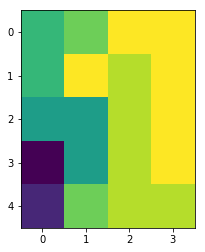

In [28]:
print(Res)
plt.imshow((1/num_itr)*Res)

In the following block we test the caterpillar tree 

In [54]:
# Testing parameters
N_vec = np.arange(500,5500,500)
m_vec = np.power(2,[6,7,8,9,10])
#m_vec = np.power(2,[6])
num_itr = 10
jc = Jukes_Cantor()
mutation_rate = [jc.p2t(0.95)]

# Construct data of type 'tree' from class dendropy
tree_list = [lopsided_tree(num_taxa=m) for m in m_vec] 

Res_cat = np.zeros((len(m_vec),len(N_vec)))
for tree_idx,tree in enumerate(tree_list):
        for _ in range(num_itr):            
            observations,evolver = simulate_sequences(seq_len=max(N_vec), tree_model=tree, seq_model=jc, mutation_rate=mutation_rate)
            for n_idx,n in enumerate(N_vec):
                X = observations[:,0:n]
                m = X.shape[0]                
                S = JC_similarity_matrix(X)
                [D,V] = np.linalg.eigh(S)
                I = np.argsort(V[:,-2])                
                split_a,split_b=I[:round(len(I)/2)],I[round(len(I)/2):]
                if np.array_equal(np.sort(split_a),np.arange(0,m/2,1)) or np.array_equal(np.sort(split_b),np.arange(0,m/2,1)):
                    Res_cat[tree_idx,n_idx] +=1


In [14]:
print(Res_cat)

NameError: name 'Res_cat' is not defined

In [7]:
# Testing parameters
#n_vec = np.arange(200,2200,200)
#m_vec = np.arange(50,650,50)
m_vec = np.power(2,[6])
#m_vec = np.arange(10,110,10)
n_vec = np.arange(100,1100,100)
jc = Jukes_Cantor()
mutation_rate = [jc.p2t(0.95)]
num_itr = 10

# Construct a matrix of trees
tree_mat = [[unrooted_birth_death_tree(birth_rate=.4, death_rate=0, num_total_tips=m) for c in np.arange(num_itr)] for m in m_vec]
#tree_mat = [[lopsided_tree(num_taxa=m) for c in np.arange(num_itr)] for m in m_vec]
Res = np.zeros((len(m_vec),len(n_vec)))

for m_idx,m in enumerate(m_vec):
    for tree_idx,tree in enumerate(tree_mat[m_idx]):
        observations = simulate_sequences(seq_len=max(n_vec), tree_model=tree, seq_model=jc, mutation_rate=mutation_rate)
        for n_idx,n in enumerate(n_vec):                    
            X = observations[:,0:n]              
            S = JC_similarity_matrix(X)
            [D,V] = np.linalg.eigh(S)            
            bool_bipartition = partition_taxa(V[:,-2])
            if (check_partition_in_tree(tree,bool_bipartition)):
                Res[m_idx,n_idx]+=1

                


ValueError: invalid literal for int() with base 10: 'T9'

In [25]:
print(Res)

[[ 7.  6.  6.  6.  9.  8.  9.  9.  9. 10.]]


In [ ]:
print(Res_cat)

True
hurray!


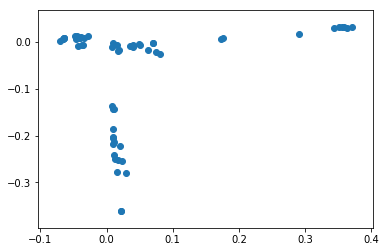

In [12]:
m_vec = np.arange(100,600,100)
n_vec = np.arange(100,1000,100)
num_itr = 10
jc = Jukes_Cantor()
mutation_rate = jc.p2t(0.85)
tree = unrooted_birth_death_tree(birth_rate=1., death_rate=0, num_total_tips=m)
#tree = lopsided_tree(num_taxa=m)
#tree.taxon_namespace = default_namespace(m)
#print(tree.taxon_namespace)
#tree.print_plot(width=60)


observations,evolver = simulate_sequences(seq_len=n, tree_model=tree, seq_model=jc, mutation_rate=mutation_rate)

S = JC_similarity_matrix(observations)
[D,V] = np.linalg.eigh(S)
fiedler_v2 = V[:,-2]
v_sort = np.sort(V[:,-2])
#plt.plot(V[:,-2],'s')
#plt.plot(V[:,-3],'s')
plt.scatter(V[:,-2],V[:,-3])
gaps = v_sort[1:m]-v_sort[0:m-1]
max_idx = np.argmax(gaps)
threshold = (v_sort[max_idx]+v_sort[max_idx+1])/2
bool_bipartition = fiedler_v2<threshold
print(check_partition_in_tree(tree,bool_bipartition))



In [3]:
a = [True,False,True]
b = [not i for i in a]
print(b)

[False, True, False]


In [41]:
ns = []
for leaf_ix, leaf in enumerate(tree.leaf_node_iter()):    
    ns.append(int(leaf.taxon.label[1:]))
print(ns)

#tree.print_plot(width=60)
ns_idx = np.argsort(np.array(ns))
print(ns_idx)




[6, 4, 7, 2, 1, 8, 3, 5]
[4 3 6 1 7 0 2 5]


In [13]:
print(type(observations))

<class 'numpy.ndarray'>


In [12]:
print(observations)

[[1 0 2 ... 1 3 0]
 [1 3 1 ... 0 2 1]
 [1 3 1 ... 0 2 1]
 ...
 [1 0 2 ... 1 2 1]
 [1 0 2 ... 1 2 1]
 [1 0 2 ... 1 2 1]]


In [11]:
tree.print_plot(width=60)

/------------------------------------------------------- T7 
|                                                           
|                               /----------------------- T15
|                       /-------+                           
|                       |       |       /--------------- T16
|                       |       \-------+                   
|                       |               |       /------- T8 
|                       |               \-------+           
|               /-------+                       \------- T3 
+               |       |                                   
|               |       |                       /------- T13
|               |       |               /-------+           
|               |       |               |       \------- T4 
|       /-------+       \---------------+                   
|       |       |                       |       /------- T10
|       |       |                       \-------+           
|       |       |       

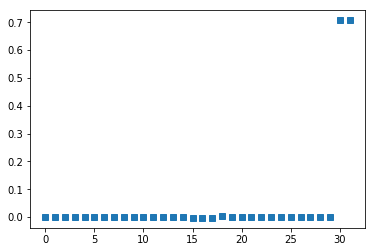

In [31]:
plt.plot(V[:,-],'s')